I've started on something of an experiment to explore how I can improve Clojure start-up time. I was curious what impact compression level has on start-up latency for JVM applications. A simple clojure application was created `(+ 1 2 3)` and packaged into an uberjar. Four Zip compression levels were tested 0, 1, 6, and 9. The uberjar was unpacked and then repacked using the linux command line zip tool as follows:

```
zip -r -0 ../main_c0.jar *
zip -r -1 ../main_c1.jar *
zip -r -6 ../main_c6.jar *
zip -r -9 ../main_c9.jar *
```

All applications, screen-locks, system sleep, and anti-virus were closed to minimise interference. A test was devised which executes the 4 uberjars 100 times each. I will refer to each uberjars execution set as a run. Every 10 executions a sleep of 30s is used to settle the system as well as writing an 8MB file to flush disk caches. See the test runner shell script below for exact details. The test was left to execute and the results from the first run were discarded as a "warm-up" cycle.

## Hypothesis

- H0 - compression level will not have an impact on application start-up time.
- Ha - compression level will have an impact on application start-up time.
- p-level - 0.1.

## Results

The results are below in ms for the execution time.

### Run 2 Results

| (ms)   | C0  | C1  | C6  | C9  |
|--------|-----|-----|-----|-----|
| 25PCTL | 570 | 616 | 613 | 613 |
| 75PCTL | 600 | 655 | 643 | 643 |
| Max    | 650 | 730 | 702 | 700 |

Overall 0 compression appears to shave 50ms from load time. Furthermore for the sample size it appears to be statistically significant.

## Next Steps

Compressing with level 0 has an obvious tradeoff for the distribution of artefact over the internet. I'd be curious to see what impact a faster algorithm such as Snappy or LZ4 has on class load performance.

For the next test I'll see what happens when the java byte code is loaded into a byte array and a custom class loader is used. This will be a baseline measurement to demonstrate whether I can write a ClassLoader which is faster than the default JAR loader.

### Notes

For future tests I would probably reduce the number of runs in the warm-up to 10 or 20 executions per jar rather than 100.

### Test Runner

```
#!/bin/sh

JARS="main_c0.jar main_c1.jar main_c6.jar main_c9.jar"

for JAR in $JARS; do
	B=0
	OUT="${JAR}-results-r1.txt"	
	SORTED="${JAR}-sorted-results-r1.txt"
	echo "starting test ${OUT}"
	while [ $B -lt 10 ]; do
		# try to flush the disk cache
		dd if=/dev/zero of=/tmp/rando.txt bs=4096 count=2048
		rm /tmp/rando.txt
		A=0
		while [ $A -lt 10 ]; do
			java -jar $JAR >> "$OUT"
			A=`expr $A + 1`
		done

		sleep 30
		B=`expr $B + 1`
	done
	cat $OUT | sort -n > $SORTED
done

for JAR in $JARS; do
	B=0
	OUT="${JAR}-results-r2.txt"	
	SORTED="${JAR}-sorted-results-r2.txt"
	echo "starting test ${OUT}"
	while [ $B -lt 10 ]; do
		# try to flush the disk cache
		dd if=/dev/zero of=/tmp/rando.txt bs=4096 count=2048
		rm /tmp/rando.txt
		A=0
		while [ $A -lt 10 ]; do
			java -jar $JAR >> "$OUT"
			A=`expr $A + 1`
		done

		sleep 30
		B=`expr $B + 1`
	done
	cat $OUT | sort -n > $SORTED
done

for JAR in $JARS; do
	B=0
	OUT="${JAR}-results-r3.txt"	
	SORTED="${JAR}-sorted-results-r3.txt"
	echo "starting test ${OUT}"
	while [ $B -lt 10 ]; do
		# try to flush the disk cache
		dd if=/dev/zero of=/tmp/rando.txt bs=4096 count=2048
		rm /tmp/rando.txt
		A=0
		while [ $A -lt 10 ]; do
			java -jar $JAR >> "$OUT"
			A=`expr $A + 1`
		done

		sleep 30
		B=`expr $B + 1`
	done
	cat $OUT | sort -n > $SORTED
done
```

In [3]:
%matplotlib inline

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

rounds = 2 # ignore the first round
levels = ['0', '1', '6', '9']
runs = []
for i in range(len(levels)*2):
    col = i % len(levels)
    run = 2 + math.floor(i/len(levels))
    level = levels[col]
    
    filename = 'main_c{}.jar-results-r{}.txt'.format(level, run)
    df = pd.read_csv(filename, header=None)
    df.columns = [level]
    if col == 0:
        runs.append(df)
    else:
        runs[run-2] = pd.concat([runs[run-2], df], axis=1, join='inner')

In [4]:
second = runs[0]
third = runs[1]

result = stats.ttest_ind(second['0'].as_matrix(), second['1'].as_matrix(), equal_var = False)
print("significant:", result.pvalue < 0.01)
result = stats.ttest_ind(third['0'].as_matrix(), third['1'].as_matrix(), equal_var = False)
print("significant:", result.pvalue < 0.01)

significant: True
significant: True


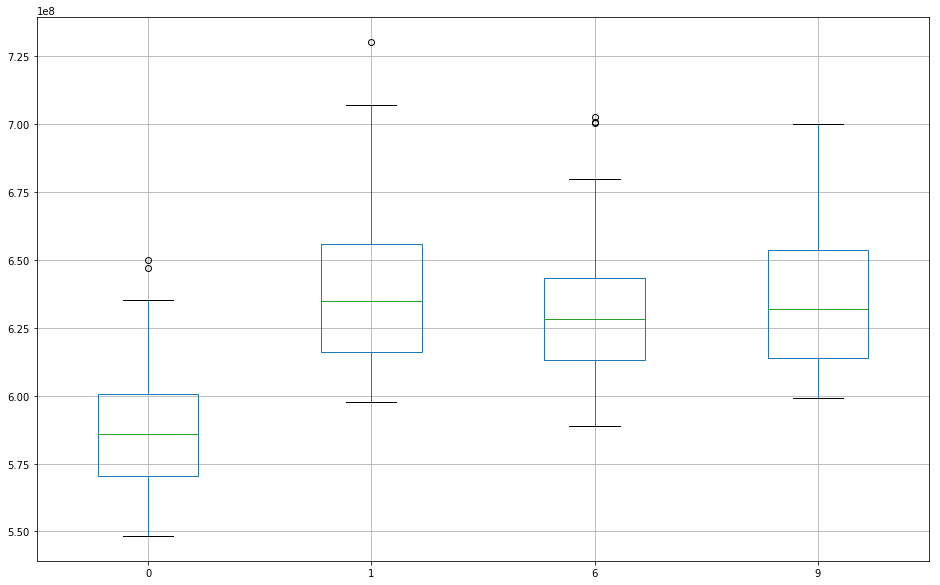

,0,1,6,9
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,5.881217e+08,6.383170e+08,6.315500e+08,6.359029e+08
std,2.315387e+07,2.728576e+07,2.389348e+07,2.511420e+07
min,5.482715e+08,5.976797e+08,5.886895e+08,5.992121e+08
25%,5.702272e+08,6.161399e+08,6.131123e+08,6.137505e+08
50%,5.857689e+08,6.348973e+08,6.281904e+08,6.318848e+08
75%,6.007704e+08,6.557159e+08,6.432410e+08,6.535822e+08
max,6.500378e+08,7.302775e+08,7.024601e+08,7.001149e+08


In [15]:
plt.figure(figsize=(16,10))
second.boxplot()
plt.show()
second.describe()

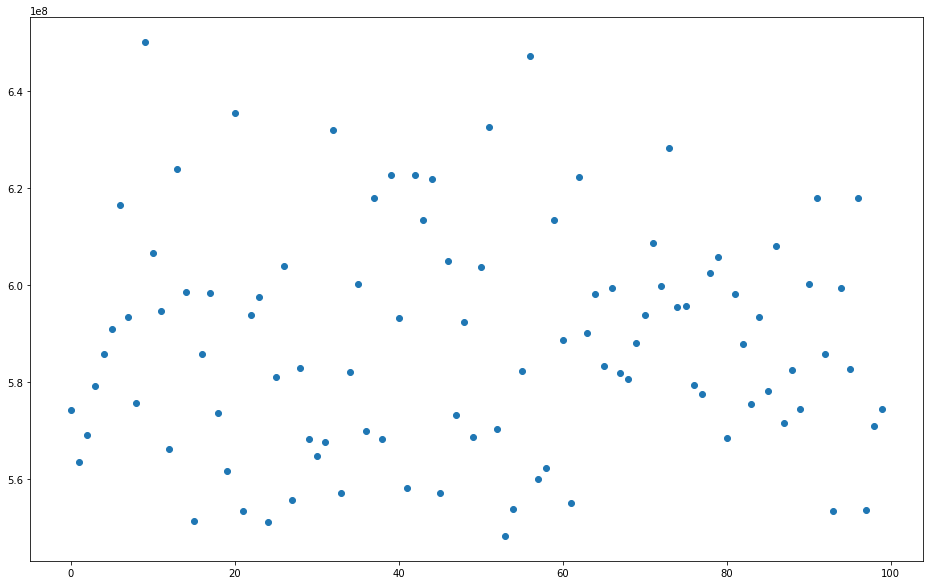

In [25]:
plt.figure(figsize=(16,10))
plt.scatter(second.index, second['0'])
plt.show()

,0,1,6,9
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,5.930233e+08,6.396256e+08,6.400394e+08,6.367756e+08
std,2.329890e+07,2.869792e+07,2.741453e+07,2.147787e+07
min,5.492006e+08,5.981918e+08,5.975137e+08,5.967547e+08
25%,5.763274e+08,6.124102e+08,6.183124e+08,6.200072e+08
50%,5.919177e+08,6.386069e+08,6.330692e+08,6.364510e+08
75%,6.073691e+08,6.594419e+08,6.559583e+08,6.516836e+08
max,6.641747e+08,7.121491e+08,7.251308e+08,7.028247e+08


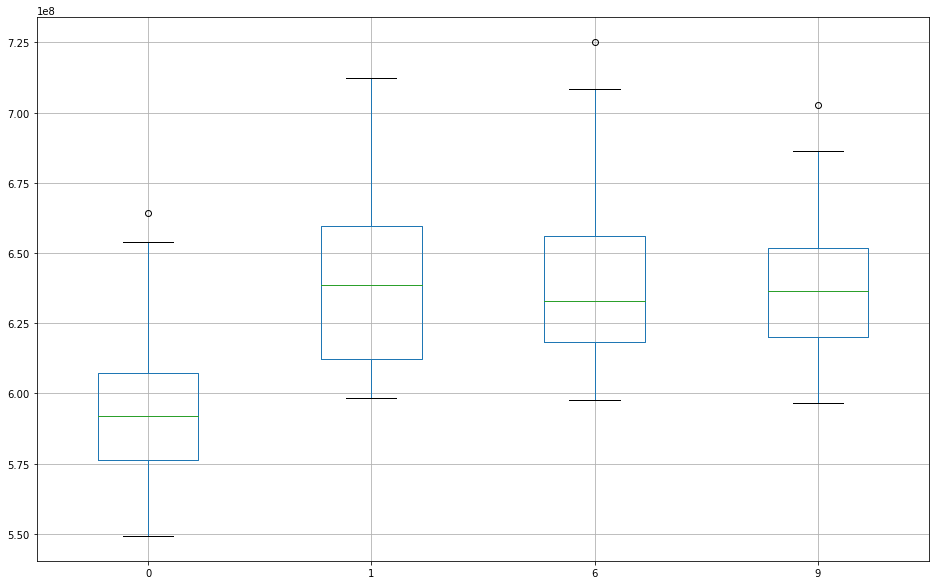

In [17]:
plt.figure(figsize=(16,10))
runs[1].boxplot()
runs[1].describe()